In [1]:
import numpy as np
from QPGC import QPGenericConstraints
import matplotlib.pyplot as plt

First of all, we will generate the two datasets as specified by the statement. We will define a function that returns the needed configuration of the dataset.

In [2]:
def generateDataset(n, separable=True):
    m1 = np.array([0., 0.])
    s1 = np.array([[1., -0.9], [-0.9, 1.]])

    if separable:
        m2 = np.array([3., 6.])
        s2 = np.array([[1., 0.], [0., 1.]])
    else:
        m2 = np.array([1., 2.])
        s2 = np.array([[1., 0.], [0., 1.]])

    pos_samples = np.random.multivariate_normal(m1, s1, n)
    neg_samples = np.random.multivariate_normal(m2, s2, n)

    x = np.concatenate((pos_samples, neg_samples)).T
    y = np.concatenate((np.ones(n), -1*np.ones(n)))

    return x,y

Also, we need to define the matrices that define our problem to minimize. It can be found in equation (8) of the statement. We need to solve that problem by using the QPGenericConstraints library and the structure found in equation (9) of the statement. For that reason, matching each part of both formulas, we obtain the name and the content of each one of the matrices.

In [3]:
def generateMatrices(x, y, K):
    # Inital scalar variables
    n = x.shape[1] # Number of samples
    p = 1 # Due to the needed shape of A
    m = 2*n # Given in the exercise
    N = n + p + 2*m # Dimension of KKT Matrix (given in KKT System desc.)

    # Initial vector/matrix variables
    A = y.reshape(n, p) # Due to the constraint A.T * x = b
    b = np.zeros(p) # b is in R^{p} in the problem description. b is all zeros in A.T * x = b
    
    C = np.concatenate((np.eye(n), -np.eye(n)), axis = 1) # Given in the exercise
    d = np.concatenate((np.zeros(n), -K*np.ones(n))) # d is in R^m in the problem description, given in the exercise TODO
    
    Y = np.diag(y) # Transformation needed to compute G
    G = np.dot(np.dot(Y, x.T), np.dot(x, Y)) # Given in the exercise
    g = -np.ones(n) # Given by the exercise: Normal Distribution

    return A, b, C, d, G, g

Once the problem is minimized, we will need to compute our hyperplane. As we now know the values of $\alpha$, we can compute both w and b with the given formulas in the statement.

During some of the experiments performed afterwards, we noticed that sometimes some of the points would fall inside the margins of the hyperplane (when it was not expected for it to happen). We identified that that would happen because we were choosing an arbitrary point in order to compute b. 

In order to avoid that, we need to compute b using the point of a class that is the closest to the other class (given that we are in a binary classification problem). For that reason, at the beginning of this method, we check which is the closest pair of points of different classes, and then use one of them to compute b. This search is costy.

In [17]:
def compute_hyperplane(alpha, X, y):
    # Choosing that "best" point 
    min_dist = np.inf
    best_pair = None
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if y[i] * y[j] < 0:
                dist = np.linalg.norm(X.T[i,:] - X.T[j,:])
                if dist < min_dist:
                    min_dist = dist
                    best_pair = (i, j)

    # Compute w
    w = np.sum(alpha * y * X, axis=1)

    # Compute b
    b = y[best_pair[0]] - np.dot(w.T, X.T[best_pair[0],:])

    return w, b

# Experiment 1: 2 points for each class

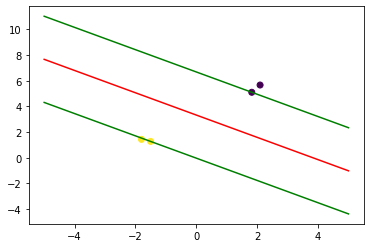

In [13]:
# Generate dataset
X, y = generateDataset(2)

# Generate matrices
A, b, C, d, G, g = generateMatrices(X, y, 1)

# Compute alpha 
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Compute hyperplane
w, b = compute_hyperplane(alpha, X, y)

# Plot points, margins and hyperplane
linespace = np.linspace(-5, 5, 100)

plt.scatter(X[0,:], X[1,:], c=y)
plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
plt.show()

To perform this experiment, we generate the datasets with the suggested configuration. Then, we generate the matrices, minimize the problem to obtain alpha, compute the hyperplane and plot. As expected, the hyperplane splits both separable classes correctly, leaving all points outside its confidence margins. Due to the way we are computing b, there will be two points which are known as support vectors.

It was in this experiment where we discovered we should change the way we computed b.

# Experiment 2: 100 points for each class

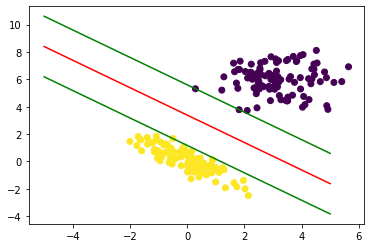

In [18]:
# Generate dataset
X, y = generateDataset(100)

# Generate matrices
A, b, C, d, G, g = generateMatrices(X, y, 1)

# Compute alpha 
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Compute hyperplane
w, b = compute_hyperplane(alpha, X, y)

# Plot points, margins and hyperplane
linespace = np.linspace(-5, 5, 100)

plt.scatter(X[0,:], X[1,:], c=y)
plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
plt.show()

Now, we had to check if the implementation was solid towards the amount of points involved. As expected, it worked perfectly fine.

# Experiment 3: different values of K and check stability

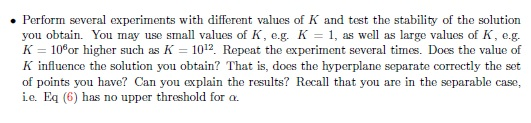

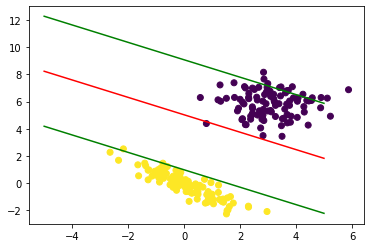

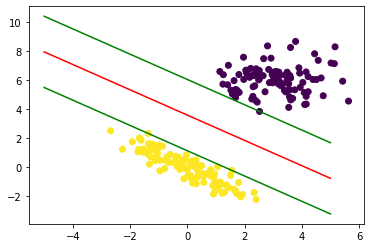

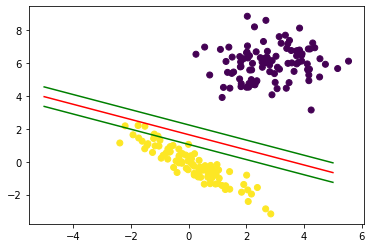

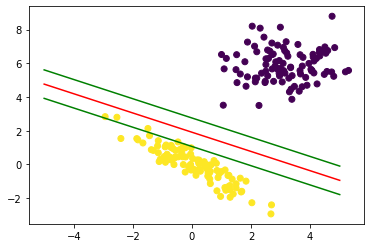

LinAlgError: Singular matrix

In [26]:
for K in [1e-3, 1, 1e3, 1e6, 1e12]:
    # Generate dataset
    X, y = generateDataset(100)

    # Generate matrices
    A, b, C, d, G, g = generateMatrices(X, y, K)

    # Compute alpha 
    alpha = QPGenericConstraints(G, g, A, C, b, d)

    # Compute hyperplane
    w, b = compute_hyperplane(alpha, X, y)

    # Plot points, margins and hyperplane
    linespace = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:], c=y)
    plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
    plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
    plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
    plt.show()

We just checked the stability of our implementation to several values of K. For a small value of K, the method finds a separating hyperplane but struggles at respecting the desired margins.

For higher values of K, the hyperplanes lay way too close to the yellow class, when a parallel hyperplane a little more above would have been an optimal solution. Then, for a even higher value of K (generally at $K = 1e6$, but always at $K = 1e12$), our matrix G shows a way too large value in the first row first column cell, which does not allow the QPGenericConstraints library to converge to a solution.

# Experiment 4: non-separable case, different values of K and check stability

<img src="data:image/png;base64,

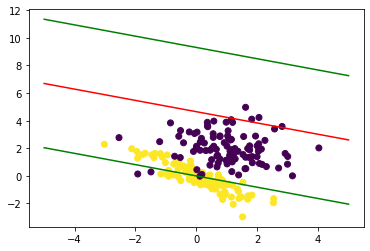

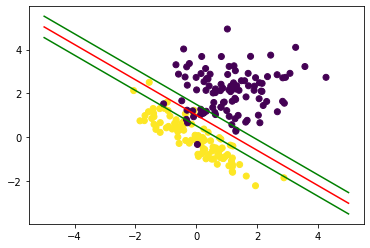

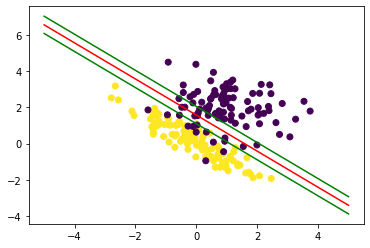

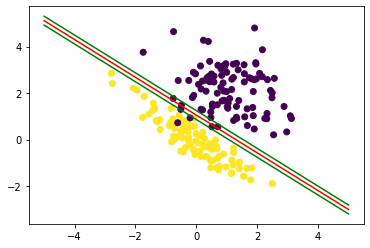

LinAlgError: Singular matrix

In [27]:
for K in [1e-3, 1, 1e3, 1e6, 1e12]:
    # Generate dataset
    X, y = generateDataset(100, separable=False)

    # Generate matrices
    A, b, C, d, G, g = generateMatrices(X, y, K)

    # Compute alpha 
    alpha = QPGenericConstraints(G, g, A, C, b, d)

    # Compute hyperplane
    w, b = compute_hyperplane(alpha, X, y)

    # Plot points, margins and hyperplane
    linespace = np.linspace(-5, 5, 100)

    plt.scatter(X[0,:], X[1,:], c=y)
    plt.plot(linespace, -(w[0]*linespace + b) / w[1], 'r')
    plt.plot(linespace, -(w[0]*linespace + b+1) / w[1], 'g')
    plt.plot(linespace, -(w[0]*linespace + b-1) / w[1], 'g')
    plt.show()

We were requested to repeat the previous experiment but with a non-separable dataset. Lower Ks fail to work properly as most of the samples lay in the margins. Higher Ks are more suitable in this case, as the hyperplane will seek to lay just as in the middle of both classes as possible. Of course, as it happened before, the highest K values will cause a divergence and make the code crash.